# Decomposing Time Series

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = sns.load_dataset('flights')

In [3]:
df.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


create date column with type string

In [5]:
dates = df['year'].astype(str) + ' ' + df['month'].astype(str)

format column to datatime and set it as the index of the df

In [6]:
dates.name = 'month in year'

In [7]:
df.set_index(pd.to_datetime(dates), inplace=True)

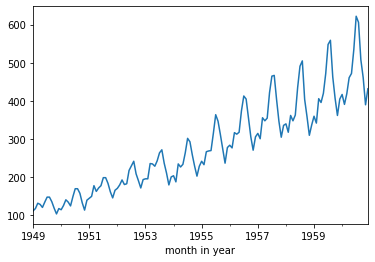

In [8]:
df['passengers'].plot()

it is possible to zoom in via df.loc

the x-axis of the plot is self-adjusting

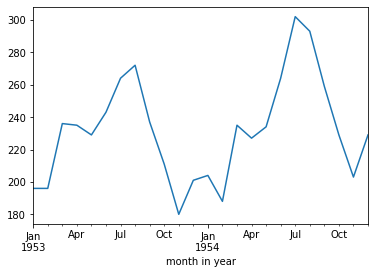

In [9]:
df.loc['1953-01-01':'1954-12-31', 'passengers'].plot()

### Decomposition:
y = trend + variance change + seasonality + X + noise 

*decomposition can be done using the human eye*

*the X + noise (more complicated patterns) can probability recognized by a machine learning algorithms*

i do not want the model to predict the trend or the seasonality because it is already visible (e.g. if i want to predict the weather)

### Differential: Trend

In [10]:
df['diff'] = df['passengers'].diff() # differential
# just the difference between the previous and the current count

In [11]:
df['diff'].mean()

2.237762237762238

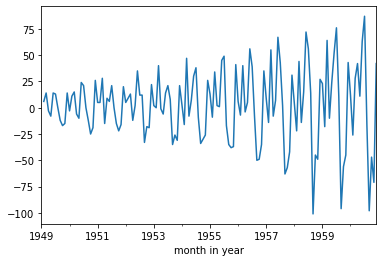

In [12]:
df['diff'].plot()

#### Percentage change
removes trend and variance change

In [13]:
df['pct'] = df['passengers'].pct_change()

In [14]:
df['pct'].mean()
# every month, the passenger number grows by that many % (*100)

0.0151685356581768

In [15]:
df.head()

,year,month,passengers,diff,pct
month in year,,,,,
1949-01-01,1949,January,112,NaN,NaN
1949-02-01,1949,February,118,6.0,0.053571
1949-03-01,1949,March,132,14.0,0.118644
1949-04-01,1949,April,129,-3.0,-0.022727
1949-05-01,1949,May,121,-8.0,-0.062016


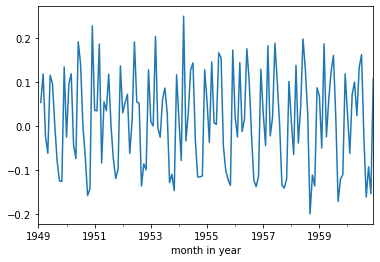

In [16]:
df['pct'].plot()

#### Seasonality

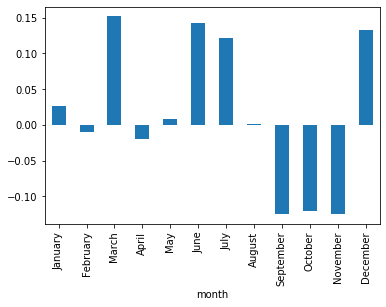

In [17]:
# monthly means
mm = df.groupby('month')['pct'].mean()
mm.plot.bar()

In [18]:
# we need a Series that is as long as our df
df.shape

(144, 5)

In [19]:
df.head(20)

,year,month,passengers,diff,pct
month in year,,,,,
1949-01-01,1949,January,112,NaN,NaN
1949-02-01,1949,February,118,6.0,0.053571
1949-03-01,1949,March,132,14.0,0.118644
1949-04-01,1949,April,129,-3.0,-0.022727
1949-05-01,1949,May,121,-8.0,-0.062016
1949-06-01,1949,June,135,14.0,0.115702
1949-07-01,1949,July,148,13.0,0.096296
1949-08-01,1949,August,148,0.0,0.000000
1949-09-01,1949,September,136,-12.0,-0.081081


In [20]:
mm.shape

(12,)

In [21]:
df['month_means'] = list(mm) * 12

In [22]:
df['detrend_div'] = df['pct'] / df['month_means']

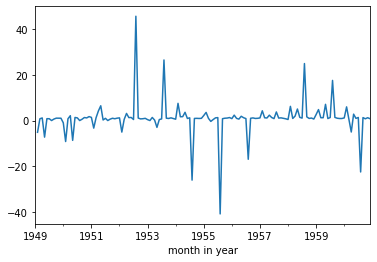

In [23]:
df['detrend_div'].plot() # identifies outliers

In [24]:
df['detrend_div'].mean()

0.9999999999999998

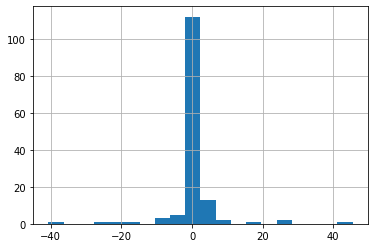

In [25]:
df['detrend_div'].hist(bins=20)#

In [26]:
df['detrend_sub'] = df['pct'] - df['month_means']

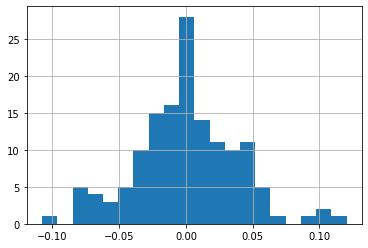

In [27]:
df['detrend_sub'].hist(bins=20) # subtraction is more robust

#### Other
- logarithms
- Box-Cox-Transform

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

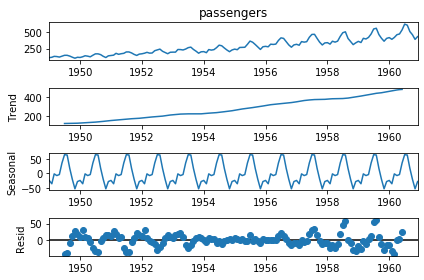

In [29]:
# additive == diff
x = seasonal_decompose(df['passengers'])
plot = x.plot() # plot= because it prints plot twice otherwise

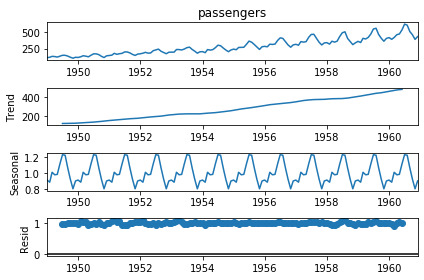

In [30]:
# multiplicative == diff
x2 = seasonal_decompose(df['passengers'], model='multiplicative')
plot2 = x2.plot()

### 1. Train/ Test Split

In [85]:
train = df.iloc[:120].copy() # copy prevents warnings
test = df.iloc[120:].copy()

### 2. Linear Regression

In [86]:
from sklearn.linear_model import LinearRegression

In [87]:
X = train.index.astype(int).values/1000_000_000_000
X = X.reshape(-1,1)
X.shape

(120, 1)

In [88]:
y = train['passengers']

In [89]:
m = LinearRegression()
m.fit(X, y)
m.score(X, y) # R2 (1.0 good, 0.0 - bad)

0.8353841974934071

In [90]:
Xtest = test.index.astype(int).values/1000_000_000_000
Xtest = Xtest.reshape(-1, 1)
ytest = test['passengers']

In [91]:
m.score(Xtest, ytest)

-0.0036751963864083415

In [92]:
ypred = m.predict(Xtest)
ytrpred = m.predict(X)

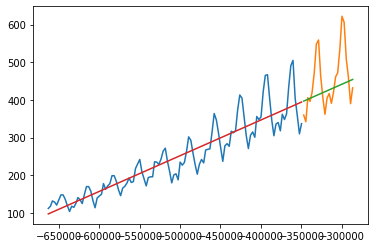

In [93]:
plt.plot(X, y)
plt.plot(Xtest, ytest) # we did not mess up the scaling of the data
plt.plot(Xtest, ypred)
plt.plot(X, ytrpred)
# works as a baseline model
# LinearReg catches the trend in the data (as it is the most pronounced feature in the data)

In [94]:
from sklearn.metrics import mean_squared_error

In [95]:
mean_squared_error(ytest, ypred) # high variance in the test data (orange)

5597.182921748128

In [96]:
mean_squared_error(y, ytrpred) # variance in the training data is less 

1471.4814419978215

### 3. Other Naive Models

In [97]:
# 3a) predict the mean
mean = y.mean()
ymean = [mean] *24 # create list with the same value 24 times

In [98]:
# #b) predict the last value seen
last = y[-1]
ylast = [last] * 24

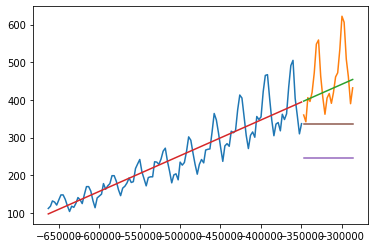

In [99]:
plt.plot(X, y)
plt.plot(Xtest, ytest) 
plt.plot(Xtest, ypred)
plt.plot(X, ytrpred)
plt.plot(Xtest, ymean) # bad model
plt.plot(Xtest, ylast) # little bit better than the ymean

if we decompose our time series, then maybe the data becomes sufficiently straightforward so that the LinearRegression will work

In [123]:
train['diff'] = train['passengers'].diff() # differential
train['pct'] = train['passengers'].pct_change()

In [124]:
mean = train['diff'].mean()
ypred_meandiff = [mean] * 24 # will be on a different scale, because it is a list of differences, not of actual values

In [125]:
mean = train['pct'].mean()
ypred_meanpct = [mean] * 24

In [126]:
# we have to do the opposite of the differential to reconstruct to the original scale:
# opposite of the diff: cumulative sum
import numpy as np
ypred_md = np.cumsum(ypred_meandiff) + last

In [127]:
# opposite of the pct change: cumulative product
ypred_mp = np.cumprod(ypred_meanpct) * last
ypred_mp

array([5.02528181e+00, 7.49360750e-02, 1.11743292e-03, 1.66629535e-05,
       2.48474888e-07, 3.70521167e-09, 5.52514327e-11, 8.23899168e-13,
       1.22858324e-14, 1.83204065e-16, 2.73190521e-18, 4.07376663e-20,
       6.07472562e-22, 9.05851874e-24, 1.35078960e-25, 2.01427252e-27,
       3.00364601e-29, 4.47898150e-31, 6.67897456e-33, 9.95956361e-35,
       1.48515175e-36, 2.21463088e-38, 3.30241669e-40, 4.92450283e-42])

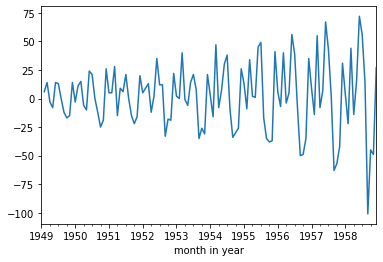

In [102]:
train['diff'].plot()

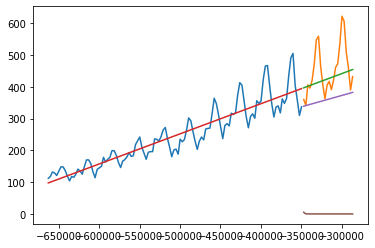

In [128]:
plt.plot(X, y)
plt.plot(Xtest, ytest) 
plt.plot(Xtest, ypred)
plt.plot(X, ytrpred)
plt.plot(Xtest, ypred_md)
plt.plot(Xtest, ypred_mp)
